## ECON 2355 Implementation Exercise 5: Contrastive Learning

This exercise introduces Contrastive Learning, focusing on supervised contrastive learning. Many social science applications of Deep Learning naturally present as a contrastive learning problem, including OCR, topic classification, passage retrieval, etc. The exercise has four main parts:

1. Introduction to Pytorch Loss functions.
2. Implementing Supervised Contrastive Loss.
3. Training a character recognition model with SupCon Loss.

Model training should be relatively short with a T4 or A100 GPU. **If you are unable to use a Colab GPU for this exercise, please reach out via email and we can create an alternate plan.**

### Notes on the class's implementation exercises in general:

 - These exercises are still being finalized! If you encounter problems please don't hesitate to reach out: tom_bryan@fas.harvard.edu

 - You are welcome to download these notebooks and complete them on your local machine, or work on them in colab. If you are hoping to run things on your local machine you will likely want to set up an [Anaconda](https://www.anaconda.com/products/distribution) python environment and run notebooks from either [VS Code](https://code.visualstudio.com/download) or [Jupyter Lab](https://jupyterlab.readthedocs.io/en/stable/getting_started/installation.html). For your future Deep Learning-oriented endevours, knowing how to set up an environment to run the frameworks and libraries discussed here will likely be important, so it might not be a bad idea to try setting things up locally. On the other hand, working in colab is nice for reproducibility purposes--anyone can run and/or debug your code without problems.

 - Exercises in this class use [PyTorch](https://pytorch.org/get-started/locally/), the [dominant](https://www.assemblyai.com/blog/pytorch-vs-tensorflow-in-2023/) research deep learning python framework. If you have a _compelling_ reason why you wish to become more familiar with another framework, like Tensorflow, reach out and we _may_ be able to accomodate that.

 - To submit the assignements, please save the exercise as a `.ipynb` file named `ECON_2355_Exercise_{n}_{firstname}_{lastname}.ipynb` and submit to the appropriate place in Canvas.  

 - These exercises are graded as complete/incomplete. _Complete_ is defined as showing effort to complete at all of the steps.


### 1. Pytorch Loss Functions Example

Pytorch supports a wide range of loss functions. Given a set of model outputs and some labels, they provide a measurement of the model's performance. In this first exercise, you will implement a commonly used loss function, Cross Entropy Loss.

As we've seen in these exercises, [Cross Entropy Loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html) is commonly used for classification problems. For each labeled data instance, it accepts a set of probabilities, one per class, and a true class label. It then computes:

$$L_i = -log\frac{exp(x_{i, c'})}{\sum_{c=1}^{C} exp(x_{i, c})} $$

Where $c'$ is the correct, $C$ is the set of all possible classes, $i \in \{1, ..., N\}$ with $N = \text{batch size}$, and $x_{i, c}$ is the predicted probability for each class for instance $i$.

In pytorch, loss functions behave much like any other module. They inherit the `torch.nn.module` class and need to implement the `forward` method. For a loss function, `forward` computes the loss given some predictions.

Pytorch has two options for pooling loss across elements in a batch: averaging and summing. The default, which we will use here, is to average the loss from each element in a batch.

As a practice, we'll start by implementing the Cross Entropy Loss function.

- **TODO:** Finish implementing CrossEntropyLoss, following the method signature and comments' advice.

_Hint_: In pytorch, selecting sets of values at specific indices is done by indexing at matched `tuples`. For example:

```[python]
[1]: ex_tensor = torch.Tensor([[1, 2, 3],
                               [4, 5, 6],
                               [7, 8, 9]])

[2]: ex_tensor[1, 1]

>> torch.Tensor([5])

[3]: ex_tensor[(0, 2, 1), (0, 1, 0)]

>> torch.Tensor([1, 8, 4])

```

Note that this requires `tuple` inputs. `ex_tensor[torch.Tensor([0, 1, 2])]` will cause an error.

In [ ]:
import torch

In [ ]:
# TODO: Implement CrossEntropyLoss
class CrossEntropyLoss(torch.nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()

    def forward(self, y_pred : torch.Tensor, y_true : torch.Tensor):
      '''
      Computes the Cross Entropy Loss for a set of predictions and true labels

      Args:
        y_pred (torch.Tensor): shape (batch_size, num_classes) Predictions for each class
        y_true (torch.Tensor): shape (batch_size,) Labels for each instances

      Returns:
        torch.Tensor: shape (1,) Loss averaged across the batch
      '''

      # Take the exponential of all predictions

      # Calculate the summed exponentials for the denominators of the Cross Entropy Loss calculation

      # Find the exponentiated values predicted for each true label

      # Divide element-wise by the denominators

      # Take the negative log and average across the batch, then return


To make sure your implementation is correct, we can verify by comparing with pytorch's implementation. Run the following cell and ensure that both loss functions produce the same value:

In [ ]:
torchCrossEntropyLoss = torch.nn.CrossEntropyLoss()
yourCrossEntropyLoss = CrossEntropyLoss()

test_preds = torch.nn.Softmax(dim=1)(torch.randn(10, 5))
test_labels = torch.randint(5, (10,))

print(torchCrossEntropyLoss(test_preds, test_labels))
print(yourCrossEntropyLoss(test_preds, test_labels))

tensor(1.6898)
tensor(1.6898)


### 2. Supervised Contrastive Loss

Contrastive loss functions train models to improve their embeddings so that similar data instances have similar embeddings. Supervised Contrastive Loss (SupCon Loss) maxminizes similarity between embeddings of the same class, and minimizes similarity between embeddings of different classes.

SupCon Loss's objective function is:

$$L = \sum_{i \in I}L_i = \sum_{i \in I}\frac{-1}{|P(i)|}\sum_{p \in P(i)}\text{log} \frac{\text{exp}(dist(z_i, z_p) / \tau)}{\sum_{a \in \{I / i\}}\text{exp}(dist(z_i, z_a) / \tau)} $$

Where:
- $I$ is the set of elements in a batch
- $P(i)$ is all elements in a batch of the same class as element $i$ (_not including $i$ itself_)
- $z_i$ is the model's embedding for element $i$
- $\tau$ is a temperature parameter. Pytorch's default is 0.1.
- $\text{dist}(z_i, z_j)$ is some distance measure between two embeddings, such that $exp(\text{dist}(z_i, z_i)) = 0$. Most implementations use _cosine similarity_, which is the dot product between two normalized vectors.

There are many similarities between Cross Entropy Loss and Sup Con Loss--it's easy to think of SupCon loss as a extension of Cross Entropy Loss to contrastive learning.

In this next section, you will create your own implementation of Supervised Contrastive Loss. The structure is very similar to the earlier Cross Entropy loss function, but a bit more complicated.

Given:
- A set of `embeddings`, a normalized $(B \times D)$ dimensional tensor ($B$ = batch size, $D$ = dimensionality). _Normalized_ means that $x \cdot x = 1$ for all embeddings.
- A set of `labels`, a $B$ dimensional tensor with integer values.
- A value for the `temperature` parameter.

Your `forward` function should compute the value specified by $L$ above, _with one exception_. Instead of providing $L$ as shown, average the loss by dividing by the batch size.

In [ ]:
!pip install pytorch-metric-learning

In [ ]:
from pytorch_metric_learning import losses
import torch

In [ ]:
# TODO: Implement mySupConLoss, following the suggestions as needed

class mySupConLoss(torch.nn.Module):
    def __init__(self):
        super(mySupConLoss, self).__init__()

    def forward(self, embeddings, labels, temp = 0.1):
        # Compute all pairwise dot products between embeddings

        # Take the exponent of all vectors, dividing by the temperature first

        # Create the denominator values, making sure to exclude the ith tensor from each
        # Tip: for each ith vector, the value value will be the same, so you can do this as a subtraction

        # Divide all the dot products by the appropriate denominator

        # Create a mask that indicates whether two embeddings are in the same category, and set values
        # whre they are not to 1, so they get zeroed by the log operation

        # Get the sum of logs of the quotients

        # Get the group sizes, but avoiding divide-by-zero errors by taking the max with 1

        # Divide by group sizes and return the negative average of those values, then return


Use the following cells to test your function. Each creates batches of normalized tensors with labels and slightly different properties, then applies the various losses. If your function produces the same results as Pytorch's you're doing great!  

In [ ]:
# Test 1: Perturbed vectors

base = torch.zeros(200, 256)
for i in range(100):
  v = torch.randn(1, 256)
  base[i] = v
  base[i+100] = v + torch.randn(1, 256) * 0.01

test_embeddings = torch.nn.functional.normalize(base)
test_labels = torch.cat((torch.arange(100), torch.arange(100)))

In [ ]:
supcon = mySupConLoss()
myloss = supcon(test_embeddings, test_labels)

loss_fn = losses.SupConLoss()
ptmlloss = loss_fn(test_embeddings, test_labels)
print('Your SupCon Loss ', myloss)
print('Pytorch\'s Supcon Loss ', ptmlloss)

Your SupCon Loss  tensor(0.0110)
Pytorch's Supcon Loss  tensor(0.0110)


In [ ]:
# Test 2: Identical vectors

base = torch.zeros(200, 256)
labels = torch.zeros(200)

for i in range(0, 200, 2):
  v = torch.randn(1, 256)
  base[i] = v
  base[i+1] = v
  labels[i] = i / 2
  labels[i+1] = i / 2

test_embeddings = torch.nn.functional.normalize(base)
test_labels = labels

In [ ]:
myloss = supcon(test_embeddings, test_labels)
print(myloss)
ptmlloss = loss_fn(test_embeddings, test_labels)
print(ptmlloss)

tensor(0.0107)
tensor(0.0107)


### 3. Contrastively Training a Character Recognizer

This section of the exercise applies Contrastive Training to its most common application: vision data. In particular, you will train a model to recognize images of english characters.

We will use a dataset of historical Newspaper text. Run the folloiwng cells to download and unpack the dataset:

In [ ]:
from huggingface_hub import hf_hub_download
REPO_ID = 'dell-research-harvard/AmericanStoriesTraining'
FILENAME = 'locca_char_crops.zip'

hf_hub_download(REPO_ID, FILENAME, repo_type="dataset", local_dir = '/content/', force_download = True)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


locca_char_crops.zip:   0%|          | 0.00/23.8M [00:00<?, ?B/s]

'/content/locca_char_crops.zip'

In [ ]:
!unzip -q locca_char_crops.zip

Two packages are crucial for our model training: `timm`, which will supply the model backbone, and `faiss`, which will perform fast vector comparisons. The following cells install them and provide some key imports

In [ ]:
!pip install timm
!pip install faiss_cpu

In [ ]:
import os
from matplotlib import pyplot as plt
import numpy as np
from torchvision import transforms as T
import timm
from timm.data import IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD
import torchvision
import math
import random
import torch
import torch.nn.functional as nn_f
import torchvision.transforms.functional as F
from tqdm import tqdm
import faiss
from pytorch_metric_learning.samplers import MPerClassSampler

There are two kinds of images in the dataset. Some character images are cropped from newspaper scans, and others are renders of types characters. The following cells show examples of each type of data:

In [ ]:
a_folder = str(ord('a'))
a_images = os.listdir(os.path.join('locca', a_folder))
paired_a_images = [os.path.join('locca', a_folder, a_img) for a_img in a_images if 'PAIRED' in a_img]
rendered_a_images = [os.path.join('locca', a_folder, a_img) for a_img in a_images if 'PAIRED' not in a_img]

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))

for i in range(4):
    axs[i].imshow(plt.imread(paired_a_images[i + 1]))
    axs[i].axis('off')

plt.show()

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))

for i in range(4):
    axs[i].imshow(plt.imread(rendered_a_images[i + 1]))
    axs[i].axis('off')

plt.show()

Now we create our vision encoder model. For this exercise, we will use the very lightweight MobileNetv3. For a more formal project, where accuracy is more crucial, a larger vision encoder will be more desireable.

This cell initializes a initial vision encoder:

In [ ]:
model = timm.create_model('mobilenetv3_small_050', num_classes = 0, pretrained=True)

The following cells handle some smaller, but crucial details in setting up the data for training. Make sure to run them, and follow comments to see what each is doing:

In [ ]:
'''
Creating SquarePad, a custom transform that takes images and pads them to a square
Crucial for applying before we resize images, so that the aspect ratio is preserved
'''
class SquarePad:
  def __call__(self, image):
    w, h = image.size
    max_wh = max(w, h)
    p_side, p_top = abs(w - max_wh) // 2, abs(h - max_wh) // 2
    return F.pad(image, (p_side, p_top, p_side, p_top), fill=255)

transform = T.Compose([
    SquarePad(),
    T.Resize((224, 224), antialias = True),
    T.ToTensor(),
    T.Normalize(IMAGENET_DEFAULT_MEAN, IMAGENET_DEFAULT_STD)
])

In [ ]:
'''
Creating the dataset using a torchvision ImageFolder. See previous exercises for a
reminder on how these are structured.
'''
full_dataset = torchvision.datasets.ImageFolder(
    root='locca',
    transform=transform,
)

In [ ]:
'''
These lines create a dictionary that maps from the default created labels (classes 0-N,
which don't correspond to the numerical image folder names) to the true character labels
'''
label_char_mapping = {}
for f_name, label in full_dataset.imgs:
  if f_name.split('/')[-1].startswith('0x') and label not in label_char_mapping.keys():
    label_char_mapping[label] = chr(int(f_name.split('/')[-1].split('_')[0], base=16))

In [ ]:
train_idxs, val_idxs, test_idxs = [], [], []
TRAIN_P, VAL_P, TEST_P = 0.8, 0.1, 0.1

# We want the train set to have all the rendered images, and 80% of the actual samples.
# The remaining 20% of real images are divided between the validation and test sets
for i, (f_name, _) in enumerate(full_dataset.imgs):
  if 'PAIRED' not in f_name:
    train_idxs.append(i)
  else:
    r = random.random()
    if r < TRAIN_P:
      train_idxs.append(i)
    elif r < TRAIN_P + VAL_P:
      val_idxs.append(i)
    else:
      test_idxs.append(i)

print(len(train_idxs), len(val_idxs), len(test_idxs))

9971 1117 1059


In [ ]:
'''
Using selected indices to partition the dataset into train, test, and validation sets.
Each Subset functions as its own dataset.
'''

train_dataset = torch.utils.data.Subset(full_dataset, train_idxs)
val_dataset = torch.utils.data.Subset(full_dataset, val_idxs)
test_dataset = torch.utils.data.Subset(full_dataset, test_idxs)

train_labels = [full_dataset.targets[i] for i in train_idxs]
val_labels = [full_dataset.targets[i] for i in val_idxs]
test_labels = [full_dataset.targets[i] for i in test_idxs]

Now that we've completed setup, we can see some samples of the final input data. Note that the fullowing examples are padded to a square,
resized to a standard 224x224 size, and normalized to create the representations below.

Training examples like these are exactly what the model will see.

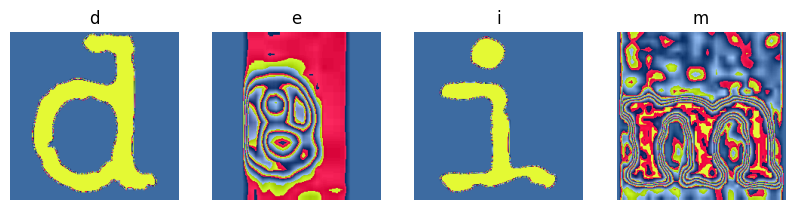

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))

for i in range(4):
    dataset_idx = i * 1000
    axs[i].imshow(F.to_pil_image(train_dataset[dataset_idx][0]))
    axs[i].axis('off')
    axs[i].set_title(label_char_mapping[train_dataset[dataset_idx][1]])

plt.show()

Supervised Contrastive training requires batches with specific properties. In particular, batches must include groups of positives for each item in each batch. The following sampler will modify typical `DataLoader` behavior to create batches that contain `batch_size / m` groups from random classes.

In [ ]:
train_sampler = MPerClassSampler(
    train_labels,
    m=4,
    length_before_new_iter=len(train_dataset),
)

These `DataLoader` objects will be used for training and testing. Note that we only use the special sampler initialized above for the train dataset. Validation and test can provide batches with any mix of classes.   

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    sampler=train_sampler,
)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=16,
)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=16,
)

Making predictions in a contrastive setting requires a template, or "anchor" set of examples. In this case, we use examples from the 'NotoSerif' typeface, which are very standard-looking characters. The following cells (1) show examples of this font and (2) create a dataset containing each example.

In [ ]:
fig, axs = plt.subplots(1, 4, figsize=(10, 3))

for i, folder in enumerate(os.listdir('locca')[:4]):
  for f_name in os.listdir(os.path.join('locca', folder)):
    if 'NotoSerif' in f_name:
      axs[i].imshow(plt.imread(os.path.join('locca', folder, f_name)))
      axs[i].axis('off')

plt.show()

In [ ]:
anchor_idxs = []
for i, (f_name, _) in enumerate(full_dataset.imgs):
  if 'NotoSerif' in f_name:
    anchor_idxs.append(i)

anchor_dataset = torch.utils.data.Subset(full_dataset, anchor_idxs)
anchor_loader = torch.utils.data.DataLoader(
    anchor_dataset,
    batch_size=16
)
print(len(anchor_dataset))

91


**Model Training**

Now we've arrived at training the model. There are a few important sections for you to fill in of the main training and evaluation loop:

1. **Training steps**: Add standard functions for pytorch training. Make sure to include zeroing the optimizer, passing data through the model, _normalizing the outputs_ (new for this problem because of the different loss funciton), computing the loss, backpropagating the gradients, and stepping the optimizer.

2. **Computing Reference Embeddings**: For each batch in the anchor dataset, pass the data through the model, normalize the outputs, and add the embeddings to the `faiss.IndexFlatL2` that is provided as `ref_index`. This is done by simply calling `ref_index.add` on the normalized embeddings.

3. **Evaluating the model**: For each batch of the validation dataset, pass the data through the model, normalize the embeddings, and look up the nearest neighbor of each embedding in the `ref_index` using `ref_index.search()`. Then compute the number of correct predictions the model made and add it to `num_correct`.

In [ ]:
## These initial lines set up everything you will need to train the model
torch.manual_seed(0) # Reproducibility
model = timm.create_model('mobilenetv3_small_050', num_classes = 0, pretrained=True) # Model initialized
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Set device
model.to(device)
model.train()
losses = []
num_epochs = 3
optimizer = torch.optim.AdamW(model.parameters(), lr=0.002) # This learning rate works well for the mobilenetv3_small_050 model
loss_func = mySupConLoss() # Using the loss function you wrote earlier.

for n in range(num_epochs):
  print(f'Training Epoch {n}')
  model.train()
  for _, (data, labels) in tqdm(enumerate(train_loader), total = int(len(train_dataset) / 16)):
    data, labels = data.to(device), labels.to(device)

    # TODO: Run the data through the model and compute the loss. Make sure to include:
    # Zero the optimizer
    # Run data through the model
    # Normalize the outputs
    # Compute the loss
    # Backpropagate the gradients
    # Step the optimizer

    losses.append(loss.item())

  model.eval()

  print('\n Creating reference embeddings')
  ref_index = faiss.IndexFlatL2(1024)
  for data, labels in anchor_loader:
    # TODO: Run the data through the model and add it to the faiss index

  num_correct = 0
  print('Evaluating')
  for _, (data, labels) in tqdm(enumerate(val_loader), total = int(len(val_dataset) / 16)):
    # TODO: Run the data through the model, find the nearest neighbor in the ref_index, and compute accuracy.

  print('\n Accuracy: ', round(num_correct / len(val_dataset), 2))


**Hard Negatives**

In the above example, the model is seeing randomized batches. However, the model will benefit much more from seeing easily confusable characters in the same batch. For example, `i` and `j` look quite similar. Focusing on those comparisons should improve model performance.

To set up this kind of batching, we first need to find sets of hard negatives. Here we create the `infer_hard_negatives` function to identify those sets. It find the four most likely candidates for each training example, and makes those a set.

**Fill in the missing sections to finish the function**

In [ ]:
def infer_hard_negatives(model, k, anchor_loader, train_loader, device, output_file = '/content/locca_hard_negatives.txt'):
  model.eval()
  ref_index = faiss.IndexFlatL2(1024)

  for data, labels in anchor_loader:
    # TODO: As above, pass the anchor set through the model and add embeddings to the ref_index

  hard_negative_sets = []
  for data, labels in tqdm(train_loader, total = int(len(train_dataset) / 16)):
    # TODO: As with the validation set above, pass the data through the model
    # This time, instead of identifying the nearest neighbor, find the k nearest neighbors in the ref_index

    for i in range(indices.shape[0]):
      hard_negative_sets.append(''.join(label_char_mapping[indices[i][j]] for j in range(k)))


  with open(output_file, 'w') as f:
    f.write('\n'.join(hard_negative_sets))



Now we can run the function. To make sure things are working correctly, open up the created folder in `/content/locca_hard_negatives.txt`. Make sure that the sets listed look like easily confusable characters.

In [ ]:
infer_hard_negatives(model, 4, anchor_loader, train_loader, device)

Just like we needed a special `Sampler` to draw batches containing groups of `m` earlier, we also need a special sampler to draw batches of hard negatives. This is implemented below:

In [ ]:
from collections import defaultdict

class_mapping = {v: k for k, v in label_char_mapping.items()}

class HardNegativeSampler(torch.utils.data.Sampler):
  def __init__(self, dataset, hard_negatives_path, class_mapping, batch_size = 16, m = 4, length_before_new_iter = None):
    self.dataset = dataset
    self.class_mapping = class_mapping
    self.m = m
    self.length_before_new_iter = len(self.dataset) if length_before_new_iter is None else length_before_new_iter
    self.batch_size = batch_size

    with open(hard_negatives_path, 'r') as f:
      hard_negative_groups = f.read().split('\n')

    self.hard_negative_groups = []
    for group in hard_negative_groups:
      self.hard_negative_groups.append([self.class_mapping[c] for c in group])

    self.indices_by_class = defaultdict(list)
    for i, (_, label) in enumerate(self.dataset):
      self.indices_by_class[label].append(i)

  def __len__(self):
    return len(self.dataset)

  def _construct_hn_batch(self, hn_group):
    hn_batch = []
    for c in hn_group:
      hn_batch.extend(random.sample(self.indices_by_class[c], self.m))

    return hn_batch

  def __iter__(self):
    num_batches = self.length_before_new_iter // self.batch_size
    idx_list = []

    for _ in range(num_batches):
      idx_list.extend(self._construct_hn_batch(random.choice(self.hard_negative_groups)))

    return iter(idx_list)

Now we create a new train loader with the HardNegativeSampler. This cell will take a few seconds to run while the DataLoader creates hard negative batches.

In [ ]:
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=16,
    sampler=HardNegativeSampler(train_dataset, '/content/locca_hard_negatives.txt', class_mapping, 16, 4, length_before_new_iter = len(train_dataset))
)

To finish the exercise, try training the model a second time, with the hard negative sampler. Copy the code from the training cell above, and train the model for 2-5 epochs. You should see slightly higher initial results, followed by slightly poorer results after a few epochs when compared with the standard, no hard negatives training from before.

This is because the model will eventually see hard negative interactions given enough batches, since there are only 91 characters in this set. In scripts with more character, like Japanese, hard negative training is much more important.

There is some stochasticity, however, so no need to worry if the training behavior is slightly different than described above.

In [ ]:
# TODO: Copy training code here and train for 2-5 epochs